In [33]:
import pandas as pd
import numpy as np
from os import remove
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy
#import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix


plt.style.use("ggplot")

Se estraen los CSV y se unifican en uno solo

In [34]:
dfRatings=pd.concat(map(pd.read_csv,glob.glob("ratings\*.csv")))
#dfRatings.rename(columns={ 'movieId' : 'id',"rating":"scored" },inplace=True)
#dfRatings.to_csv("DataRatings.csv",index=False,sep=";",encoding="utf-8")

Se realiza una copia por seguridad con el fin de no realizar cambios en el dataframe original

In [35]:
Ratings_=dfRatings.copy()

Se reviza la informacion del tipo de datos por columna 

In [36]:
Ratings_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11024289 entries, 0 to 1499999
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   rating     float64
 2   timestamp  int64  
 3   movieId    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 420.5+ MB


Se reviza la descripcion del tipo de datos por columna 

In [37]:
Ratings_.describe(include="all")

,userId,rating,timestamp,movieId
count,1.102429e+07,1.102429e+07,1.102429e+07,11024289
unique,NaN,NaN,NaN,22998
top,NaN,NaN,NaN,as4197
freq,NaN,NaN,NaN,576
mean,8.997251e+04,3.533455e+00,1.172542e+09,NaN
std,8.686601e+04,1.059692e+00,2.056774e+08,NaN
min,1.000000e+00,5.000000e-01,7.896520e+08,NaN
25%,2.855800e+04,3.000000e+00,9.901593e+08,NaN
50%,5.684300e+04,3.500000e+00,1.153610e+09,NaN
75%,1.168670e+05,4.000000e+00,1.360470e+09,NaN


Reviso si contiene nulos en alguna columnas

In [38]:
Ratings_.columns[Ratings_.isnull().any()]

Index([], dtype='object')

In [39]:
Ratings_[Ratings_["movieId"]==np.NaN]

,userId,rating,timestamp,movieId


Reviso la dimension del dataframe

In [41]:
Ratings_.shape

(11024289, 4)

Realizo un sondeo de valores unicos 

In [40]:
sorted(Ratings_["rating"].unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [42]:
gbPorRatings=pd.DataFrame(Ratings_.groupby(["userId","movieId","timestamp"],as_index=False)["rating"].agg(["min","max","mean"]))

In [72]:
gbPorRatings.sort_values("mean",ascending=False)

min  max  mean
userId movieId timestamp                 
1      as1577  1425941502  5.0  5.0   5.0
59888  as3082  1291783459  5.0  5.0   5.0
14601  ns5862  1476445386  5.0  5.0   5.0
59886  ns4165  1465414577  5.0  5.0   5.0
       ns4811  1460572974  5.0  5.0   5.0
...                        ...  ...   ...
35985  as8020  1356531334  0.5  0.5   0.5
52373  as9165  1365903581  0.5  0.5   0.5
35985  as7983  1304541083  0.5  0.5   0.5
3777   as9375  1484257812  0.5  0.5   0.5
51884  as6217  1203685618  0.5  0.5   0.5

[11023899 rows x 3 columns]

Revisamos la cantidad de valores unicos que tenemos en el ratings
Ademas los imprimimos para saber cuales son

In [73]:
print(len(sorted(gbPorRatings["mean"].unique())))
print(sorted(gbPorRatings["mean"].unique()))

18
[0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0]


Realizamos un filtro de las peliculas mejor calificadas mayores a 3.5, por los usuarios teniendo en cuanta el ratings

In [79]:
RatingsFiltrado=gbPorRatings[gbPorRatings["mean"]>3.5]

Observamos como queda muy levemente

In [80]:
RatingsFiltrado=RatingsFiltrado.reset_index()

In [81]:
RatingsFiltrado[["userId","movieId","mean","timestamp"]]

,userId,movieId,mean,timestamp
0,1,as1577,5.0,1425941502
1,1,as3004,4.0,1425942148
2,1,as4340,5.0,1425942133
3,1,as5517,4.0,1425942007
4,1,as6112,5.0,1425941593
...,...,...,...,...
5507330,270896,ns8650,5.0,1257031453
5507331,270896,ns8686,4.0,1257034287
5507332,270896,ns8706,5.0,1257032032
5507333,270896,ns8715,5.0,1257031719


cambiamos el nombre de la columna mean por Ratings

In [82]:
RatingsFiltrado.columns=["userId","movieId","timestamp","min","max","ratings"]

<Axes: xlabel='ratings', ylabel='count'>

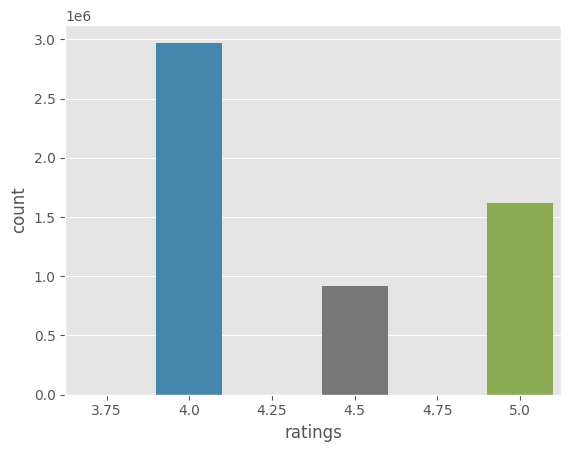

In [83]:
sns.countplot(x="ratings",data=RatingsFiltrado)

In [84]:
InfoPelis_=pd.read_csv("DataPlataformas.csv",sep=";",usecols=[0,2,8])
# 0=id
# 2=title
# 8=listed_in

In [85]:
InfoPelis_.head(1)

,id,title,listed_in
0,as1,the grand seduction,"comedy, drama"


Realizo una inspencion del dataset donde me muestre los valores unicos, faltantes el top.

In [ ]:
InfoPelis_.describe(include="all")

,id,title,listed_in
count,22998,22998,22998
unique,22998,22041,1687
top,as1,married at first sight,drama
freq,1,4,1061


Unimos el dataset de los ratings, con el dataset de los titulos de las peliculas teniendo como base los id de las peliculas
Este dataset nuevo sera la base para realizar el ML

In [86]:
rated_movies=RatingsFiltrado.merge(InfoPelis_,left_on="movieId",right_on="id")[["userId","movieId","title","ratings","listed_in"]]

Revisamos la descripcion estadistica

In [87]:
rated_movies.describe(include="all")

,userId,movieId,title,ratings,listed_in
count,5.507335e+06,5507335,5507335,5.507335e+06,5507335
unique,NaN,22998,22041,NaN,1687
top,NaN,as8751,married at first sight,NaN,drama
freq,NaN,302,965,NaN,254321
mean,9.033245e+04,NaN,NaN,4.376994e+00,NaN
std,8.694512e+04,NaN,NaN,4.394625e-01,NaN
min,1.000000e+00,NaN,NaN,3.750000e+00,NaN
25%,2.867200e+04,NaN,NaN,4.000000e+00,NaN
50%,5.724200e+04,NaN,NaN,4.000000e+00,NaN
75%,1.170560e+05,NaN,NaN,5.000000e+00,NaN


Revisamos la informacion por columnas

In [88]:
rated_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5507335 entries, 0 to 5507334
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    object 
 2   title      object 
 3   ratings    float64
 4   listed_in  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 252.1+ MB


Revisamos como nos quedo la union

In [166]:
rated_movies

,userId,movieId,title,ratings,listed_in
0,1,as1577,mr. robot,5.0,tv shows
1,667,as1577,mr. robot,4.0,tv shows
2,1244,as1577,mr. robot,5.0,tv shows
3,1586,as1577,mr. robot,4.0,tv shows
4,2008,as1577,mr. robot,4.0,tv shows
...,...,...,...,...,...
5507330,268550,hs338,la culpa es de cortés: edición mujeres,4.0,"comedy, latino"
5507331,268759,hs338,la culpa es de cortés: edición mujeres,5.0,"comedy, latino"
5507332,269859,hs338,la culpa es de cortés: edición mujeres,4.5,"comedy, latino"
5507333,270259,hs338,la culpa es de cortés: edición mujeres,4.0,"comedy, latino"


Realizamos un pivotaje del dataset ya unido con la funcion pivot_table y lo complementamos con la funcion de agregacion del promedio pero tambien usamos LA FUNCION (LEN) parA que saque el promedio, si un usuario califica varias veces la misma pelicula.

In [167]:
PromediosRaitings=rated_movies.pivot_table(index=["movieId","title","listed_in"],values="ratings",aggfunc=[len,np.mean])
PromediosRaitings

,,,len,mean
,,,ratings,ratings
movieId,title,listed_in,,
as1,the grand seduction,"comedy, drama",241,4.336100
as10,david's mother,drama,233,4.332618
as100,wilder napalm,"comedy, science fiction",236,4.381356
as1000,sinbad: make me wanna holla,"arts, entertainment, and culture, comedy, documentary",250,4.346000
as1001,simple gifts: the chamber music society at shaker village,documentary,237,4.386076
...,...,...,...,...
ns995,this lady called life,"dramas, international movies, romantic movies",212,4.367925
ns996,vizontele,"comedies, dramas, international movies",266,4.379699


Re-asignamos el nombre de la columna, ya que cada vez que realizamos el pivot_table los nombres de las columnas tienden a cambiar, cambiamos la cantidad de decimales por columna en caso que tenga

In [168]:
PromediosRaitings.columns=["ratings","Prome_Raitings"]
PromediosRaitings=PromediosRaitings.round(2)
PromediosRaitings

,,,ratings,Prome_Raitings
movieId,title,listed_in,,
as1,the grand seduction,"comedy, drama",241,4.34
as10,david's mother,drama,233,4.33
as100,wilder napalm,"comedy, science fiction",236,4.38
as1000,sinbad: make me wanna holla,"arts, entertainment, and culture, comedy, documentary",250,4.35
as1001,simple gifts: the chamber music society at shaker village,documentary,237,4.39
...,...,...,...,...
ns995,this lady called life,"dramas, international movies, romantic movies",212,4.37
ns996,vizontele,"comedies, dramas, international movies",266,4.38
ns997,homunculus,"horror movies, international movies, thrillers",239,4.41


Realizamos una ordenacion del dataset teniendo como referencia la columnas "Prome_Raitings"

In [169]:
PromediosRaitings.sort_values(by="Prome_Raitings",ascending=False)

,,,ratings,Prome_Raitings
movieId,title,listed_in,,
ns1252,dances with wolves,"action & adventure, classic movies, dramas",238,4.48
ns6650,dries,"documentaries, international movies",228,4.48
ns6707,estar o no estar,"dramas, international movies, romantic movies",233,4.48
ns5176,lady dynamite,tv comedies,251,4.48
ds1229,talespin,"action-adventure, animation, kids",234,4.47
...,...,...,...,...
as8336,casino.sk,drama,248,4.27
ds180,when sharks attack,reality,243,4.27
ds1264,the cheetah girls,"coming of age, drama, music",250,4.27


Realizamos un analisis estadistos simples de la columna "ratings"

In [170]:
print("media :" , round(PromediosRaitings["ratings"].mean(),2))
print("moda :" , round(PromediosRaitings["ratings"].mode(),2))
print("mediana :" , round(PromediosRaitings["ratings"].median(),2))
print("varianza :" , round(PromediosRaitings["ratings"].var(),2))
print("maxima :" , PromediosRaitings["ratings"].max())
print("minima :" , PromediosRaitings["ratings"].min())

media : 239.47
moda : 0    242
Name: ratings, dtype: int64
mediana : 239.0
varianza : 241.58
maxima : 302
minima : 176


Realizamos un filtra adicional el cual es: escoger la peliculas con mas de 250 ratings teniendo en cuenta la media de la cantidad de las calificaciones

In [171]:
PromediosRaitings[PromediosRaitings["ratings"]>250].sort_values(by="Prome_Raitings",ascending=False)

,,,ratings,Prome_Raitings
movieId,title,listed_in,,
ns5176,lady dynamite,tv comedies,251,4.48
ds868,"dr. t, lone star vet","docuseries, family, medical",257,4.47
as5312,vivarium,"fantasy, science fiction, suspense",271,4.47
as8659,score,drama,264,4.46
ns7160,kaakan,"dramas, international movies, romantic movies",267,4.46
...,...,...,...,...
ns2063,blue exorcist,"anime series, international tv shows",256,4.29
ns8712,weeds on fire,"dramas, independent movies, international movies",253,4.29
ns3698,war against women,"documentaries, international movies",260,4.29


Observamos de manera grafica como distribuyen los datos realizando un conteo de los datos

<Axes: xlabel='ratings', ylabel='count'>

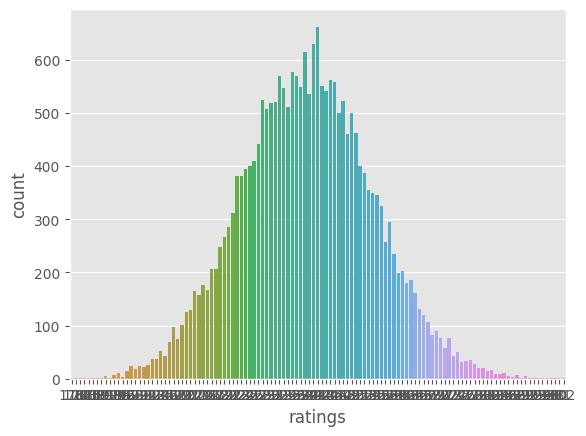

In [172]:
sns.countplot(x="ratings",data=PromediosRaitings)

In [148]:
print("media :" , round(PromediosRaitings["ratings"].mean(),2))
print("moda :" , round(PromediosRaitings["ratings"].mode(),2))
print("mediana :" , round(PromediosRaitings["ratings"].median(),2))
print("varianza :" , round(PromediosRaitings["ratings"].var(),2))
print("maxima :" , PromediosRaitings["ratings"].max())
print("minima :" , PromediosRaitings["ratings"].min())

media : 239.68
moda : 0    242
Name: ratings, dtype: int64
mediana : 239.0
varianza : 290.55
maxima : 519
minima : 176


<Axes: xlabel='Prome_Raitings', ylabel='count'>

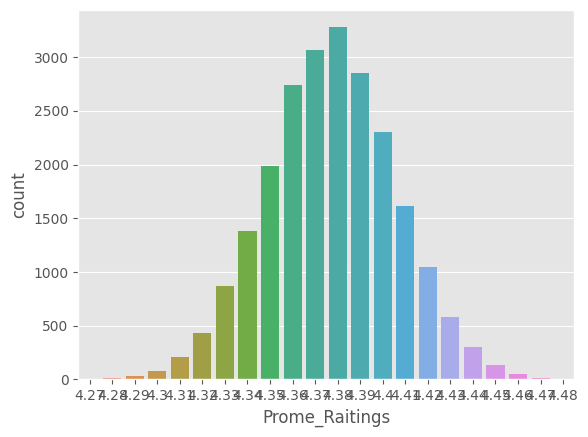

In [173]:
sns.countplot(x="Prome_Raitings",data=PromediosRaitings)

In [174]:
print("media :" , round(PromediosRaitings["Prome_Raitings"].mean(),2))
print("moda :" , round(PromediosRaitings["Prome_Raitings"].mode(),2))
print("mediana :" , round(PromediosRaitings["Prome_Raitings"].median(),2))
print("varianza :" , round(PromediosRaitings["Prome_Raitings"].var(),2))
print("maxima :" , PromediosRaitings["Prome_Raitings"].max())
print("minima :" , PromediosRaitings["Prome_Raitings"].min())

media : 4.38
moda : 0    4.38
Name: Prome_Raitings, dtype: float64
mediana : 4.38
varianza : 0.0
maxima : 4.48
minima : 4.27


Realizamos un filtro de los top 10 de las peliculas mas populares con mas 480 Rankins y mejor promedio en ratings, hasta se podria hacer una recomendacion basica con estas peliculas

Ya con este podriamos hacer una recomendacion inicial sin ML

In [187]:
a=PromediosRaitings[PromediosRaitings["ratings"]>240].sort_values(by="Prome_Raitings",ascending=False)
a.head(10)

,movieId,title,listed_in,ratings,Prome_Raitings
0,ns5176,lady dynamite,tv comedies,251,4.48
2,ds635,america's national parks,"animals & nature, docuseries",245,4.47
3,ns6265,beauty & the beast,"crime tv shows, romantic tv shows, tv dramas",247,4.47
4,as5312,vivarium,"fantasy, science fiction, suspense",271,4.47
5,ds868,"dr. t, lone star vet","docuseries, family, medical",257,4.47
6,ns413,chhota bheem and the incan adventure,children & family movies,247,4.47
7,as5151,m.f.a.,"drama, horror, suspense",247,4.47
1,as1897,le mans: racing is everything,"documentary, sports",248,4.47
26,ds1175,saludos amigos,"animation, comedy, family",255,4.46
22,ns954,the whole truth,"dramas, thrillers",247,4.46


In [176]:
a

,,,ratings,Prome_Raitings
movieId,title,listed_in,,
ns5176,lady dynamite,tv comedies,251,4.48
as1897,le mans: racing is everything,"documentary, sports",248,4.47
ds635,america's national parks,"animals & nature, docuseries",245,4.47
ns6265,beauty & the beast,"crime tv shows, romantic tv shows, tv dramas",247,4.47
as5312,vivarium,"fantasy, science fiction, suspense",271,4.47
...,...,...,...,...
ns4673,cathedral of the sea,"international tv shows, spanish-language tv shows, tv dramas",248,4.28
as8336,casino.sk,drama,248,4.27
ds180,when sharks attack,reality,243,4.27


Resteo la columna indice

In [177]:
a.reset_index()

,movieId,title,listed_in,ratings,Prome_Raitings
0,ns5176,lady dynamite,tv comedies,251,4.48
1,as1897,le mans: racing is everything,"documentary, sports",248,4.47
2,ds635,america's national parks,"animals & nature, docuseries",245,4.47
3,ns6265,beauty & the beast,"crime tv shows, romantic tv shows, tv dramas",247,4.47
4,as5312,vivarium,"fantasy, science fiction, suspense",271,4.47
...,...,...,...,...,...
10918,ns4673,cathedral of the sea,"international tv shows, spanish-language tv sh...",248,4.28
10919,as8336,casino.sk,drama,248,4.27
10920,ds180,when sharks attack,reality,243,4.27
10921,ds1264,the cheetah girls,"coming of age, drama, music",250,4.27


In [178]:
PromediosRaitings.shape

(22998, 2)

In [181]:
PromediosRaitings=a.reset_index().copy()

In [182]:
PromediosRaitings

,movieId,title,listed_in,ratings,Prome_Raitings
0,ns5176,lady dynamite,tv comedies,251,4.48
1,as1897,le mans: racing is everything,"documentary, sports",248,4.47
2,ds635,america's national parks,"animals & nature, docuseries",245,4.47
3,ns6265,beauty & the beast,"crime tv shows, romantic tv shows, tv dramas",247,4.47
4,as5312,vivarium,"fantasy, science fiction, suspense",271,4.47
...,...,...,...,...,...
10918,ns4673,cathedral of the sea,"international tv shows, spanish-language tv sh...",248,4.28
10919,as8336,casino.sk,drama,248,4.27
10920,ds180,when sharks attack,reality,243,4.27
10921,ds1264,the cheetah girls,"coming of age, drama, music",250,4.27


In [183]:
PromediosRaitings.to_csv("Recomendacion.csv",sep=",")

In [184]:
#PromediosRaitings[PromediosRaitings.index.str.contains("star wars")].head()
PromediosRaitings[PromediosRaitings["title"].str.contains("star wars", case=False, na=True, regex=True)]

,movieId,title,listed_in,ratings,Prome_Raitings
824,ds1218,star wars: the force awakens (episode vii),"action-adventure, science fiction",257,4.42
1017,ns8053,solo: a star wars story (spanish version),"action & adventure, children & family movies, ...",249,4.41
3525,ds1212,star wars: a new hope (episode iv),"action-adventure, science fiction",266,4.39
5578,ds232,star wars biomes,science fiction,258,4.38
5678,ds1008,lego star wars: the new yoda chronicles - clas...,"action-adventure, animation, comedy",263,4.38
5759,ds364,lego star wars holiday special,"action-adventure, animation, comedy",255,4.38
5764,ds477,solo: a star wars story,"action-adventure, crime, science fiction",260,4.38
5772,ds1213,star wars: attack of the clones (episode ii),"action-adventure, science fiction",254,4.38
6349,ds268,star wars: ewoks,"action-adventure, animation, fantasy",257,4.37
6391,ds328,disney gallery / star wars: the mandalorian,"action-adventure, docuseries, family",243,4.37


<h2>comenzamos a realizar el modelo de recomendaciones
Collaborative filtering

Para trabajar con Collaborative filtering, es necesario crear una matria donde las filas sean los usuarios y las peliculas de las columnas o al reves.

In [39]:
rated_movies.head()

,userId,movieId,title,ratings
0,1,as1577,mr. robot,5.0
1,667,as1577,mr. robot,4.0
2,1244,as1577,mr. robot,5.0
3,1586,as1577,mr. robot,4.0
4,2008,as1577,mr. robot,4.0


In [40]:
rated_movies.shape

(5507335, 4)

In [41]:
peli_mas_calif=pd.DataFrame(rated_movies["movieId"].value_counts())
peli_mas_calif=peli_mas_calif.reset_index()
peli_mas_calif

,movieId,count
0,as8751,302
1,ns1191,302
2,as8275,301
3,hs2172,300
4,ns5743,298
...,...,...
22993,as6227,186
22994,ns5759,183
22995,hs2597,181
22996,ns5225,178


In [42]:
print("media :" , round(peli_mas_calif["count"].mean(),2))
print("moda :" , round(peli_mas_calif["count"].mode(),2))
print("mediana :" , round(peli_mas_calif["count"].median(),2))
print("varianza :" , round(peli_mas_calif["count"].var(),2))
print("maxima :" , peli_mas_calif["count"].max())
print("minima :" , peli_mas_calif["count"].min())

media : 239.47
moda : 0    242
Name: count, dtype: int64
mediana : 239.0
varianza : 241.58
maxima : 302
minima : 176


In [43]:
peli_mas_calif_=peli_mas_calif[peli_mas_calif["count"]>239]
peli_mas_calif_

,movieId,count
0,as8751,302
1,ns1191,302
2,as8275,301
3,hs2172,300
4,ns5743,298
...,...,...
11454,as4267,240
11455,hs1328,240
11456,as6849,240
11457,ds1420,240


In [44]:
rated_movies_new_=peli_mas_calif_.merge(rated_movies,left_on="movieId",right_on="movieId")[["userId","movieId","title","ratings"]]

In [45]:
rated_movies_new_.shape

(2886798, 4)

In [46]:
print("media :" , round(rated_movies_new_["ratings"].mean(),2))
print("moda :" , round(rated_movies_new_["ratings"].mode(),2))
print("mediana :" , round(rated_movies_new_["ratings"].median(),2))
print("varianza :" , round(rated_movies_new_["ratings"].var(),2))
print("maxima :" , rated_movies_new_["ratings"].max())
print("minima :" , rated_movies_new_["ratings"].min())

media : 4.38
moda : 0    4.0
Name: ratings, dtype: float64
mediana : 4.0
varianza : 0.19
maxima : 5.0
minima : 3.75


In [47]:
rated_movies_new_["ratings"].unique()

array([4.  , 4.5 , 5.  , 3.75, 4.25])

In [48]:
rated_movies_new_=rated_movies_new_[rated_movies_new_["ratings"]>4]

In [49]:
rated_movies_new_.shape

(1328992, 4)

In [50]:
rated_movies_=rated_movies_new_[["userId","title","ratings","movieId"]].head(1328992).copy()

nos sersioramos que no hallan nulos que debamos arreglar

In [51]:
rated_movies_.isnull().any()

userId     False
title      False
ratings    False
movieId    False
dtype: bool

In [52]:
RmN=rated_movies_new_.pivot_table(index='userId',columns='title',values='ratings',aggfunc=np.mean)

In [ ]:
RmN.head()

,userId,movieId,title,ratings
5,1581,as8751,aws deepracer tv,4.5
6,2016,as8751,aws deepracer tv,4.5
7,2123,as8751,aws deepracer tv,5.0
10,4986,as8751,aws deepracer tv,5.0
13,5620,as8751,aws deepracer tv,4.5


In [ ]:
RmN.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1328992 entries, 5 to 2886796
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   userId   1328992 non-null  int64  
 1   movieId  1328992 non-null  object 
 2   title    1328992 non-null  object 
 3   ratings  1328992 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 50.7+ MB


In [ ]:
RmN.fillna(0, inplace=True)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\70287985.py", line 1, in <module>
    rt.fillna(0, inplace=True)
    ^^
NameError: name 'rt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01

In [ ]:
RmN.head()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\3147084197.py", line 1, in <module>
    rt.head()
    ^^
NameError: name 'rt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA EN

In [ ]:
type(RmN)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\2730770780.py", line 1, in <module>
    type(rt)
         ^^
NameError: name 'rt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DAT

In [ ]:
if os.path.exists("rtUserVsTitle.csv"):
    remove("rtUserVsTitle.csv")
    RmN.to_csv("rtUserVsTitle.csv",index=False,sep=";",encoding="utf-8")
  
else:
    RmN.to_csv("rtUserVsTitle.csv",index=False,sep=";",encoding="utf-8")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\1460123191.py", line 3, in <module>
    rt.to_csv("rtUserVsTitle.csv",index=False,sep=";",encoding="utf-8")
    ^^
NameError: name 'rt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 

In [ ]:
rtUserVsTitle=pd.read_csv("rtUserVsTitle.csv",sep=",")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\660903825.py", line 1, in <module>
    rtUserVsTitle=pd.read_csv("rtUserVsTitle.csv",sep=",")
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\pandas\io\parsers\readers.py", line 912, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\pandas\io\parser

In [ ]:
type(rt)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\2730770780.py", line 1, in <module>
    type(rt)
         ^^
NameError: name 'rt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DAT

In [ ]:
stttt=csr_matrix(rt)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\2925736421.py", line 1, in <module>
    stttt=csr_matrix(rt)
                     ^^
NameError: name 'rt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS 

In [ ]:
stttt

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\964264809.py", line 1, in <module>
    stttt
NameError: name 'stttt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\Fa

In [ ]:
st=csr_matrix(rtUserVsTitle)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\2141717106.py", line 1, in <module>
    st=csr_matrix(rtUserVsTitle)
                  ^^^^^^^^^^^^^
NameError: name 'rtUserVsTitle' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CUR

In [ ]:
user_similary=cosine_similarity(stttt)
#user_similary=cosine_similarity(stttt)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\CAC\AppData\Local\Temp\ipykernel_10464\762438571.py", line 1, in <module>
    user_similary=cosine_similarity(stttt)
                                    ^^^^^
NameError: name 'stttt' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CAC\Desktop\HENRY\DATA SCIENSE\1 CURSO DT08-GRUPO 03\PROYECTOS FINALES\PI 01-DT09 - DATA ENGINEER\FastApiPlataFormasData09\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\CAC\Desktop\HENRY\DATA SC

In [ ]:
#Set-ExecutionPolicy -ExecutionPolicy Remotesigned -Scope process
#.\activate